In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Población atendida por rutas

In [ ]:
from gtfs_merida import GTFSMerida

datos = "../datos"
gtfs_base_file = f"{datos}/GTFS/gtfs-merida.zip"
isocronas_pob_gpkg = f"{datos}/isocronas_mza_pob_merida_2020.gpkg"
manzanas_shp = f"{datos}/31_Manzanas_INV2020_shp/INV2020_IND_PVEU_MZA_31.shp"
bbox_merida = 3764086,1034675,3792830,1069982

def get_poblacion_atendida(rutas, iso, manz):
    mzas_ruta_total = []
    for i in rutas.index:
        if (i % 10) == 0:
            print(f"Procesando ruta {i+1} de {len(rutas)}")
        ruta_i = rutas.loc[i, "geometry"]
        mzas_ruta_iso = iso.loc[iso.intersects(ruta_i), "CVEGEO"].unique().tolist()
        mzas_ruta_total += mzas_ruta_iso

    mzas_ruta_unq = list(set(mzas_ruta_total))
    manz_rutas = manz.loc[manz["CVEGEO"].isin(mzas_ruta_unq)]
    return manz_rutas

def get_poblacion_atendida_from_gtfs(gtfs_obj, t=5):
    rutas = gtfs_obj.get_rutas()
    iso = gpd.read_file(isocronas_pob_gpkg, encoding='utf-8', layer=f"{t}_minutos_pob", columns=['CVEGEO', 'geometry'])
    manz = gpd.read_file(manzanas_shp, encoding='utf-8', bbox=bbox_merida)\
        .to_crs(epsg=4326)
    manz["POBTOT"] = manz["POBTOT"].astype(int)
    return get_poblacion_atendida(rutas, iso, manz)

t = 5
gtfs_base = GTFSMerida(gtfs_base_file)
manz_rutas_atendidas_base = get_poblacion_atendida_from_gtfs(gtfs_base, t=t)
pob_atendida_base = manz_rutas_atendidas_base["POBTOT"].sum()
print(f"Población atendida a {t} minutos: {pob_atendida_base}")

Procesando ruta 1 de 79
Procesando ruta 11 de 79
Procesando ruta 21 de 79
Procesando ruta 31 de 79
Procesando ruta 41 de 79
Procesando ruta 71 de 79
Procesando ruta 81 de 79
Población atendida a 5 minutos: 854124


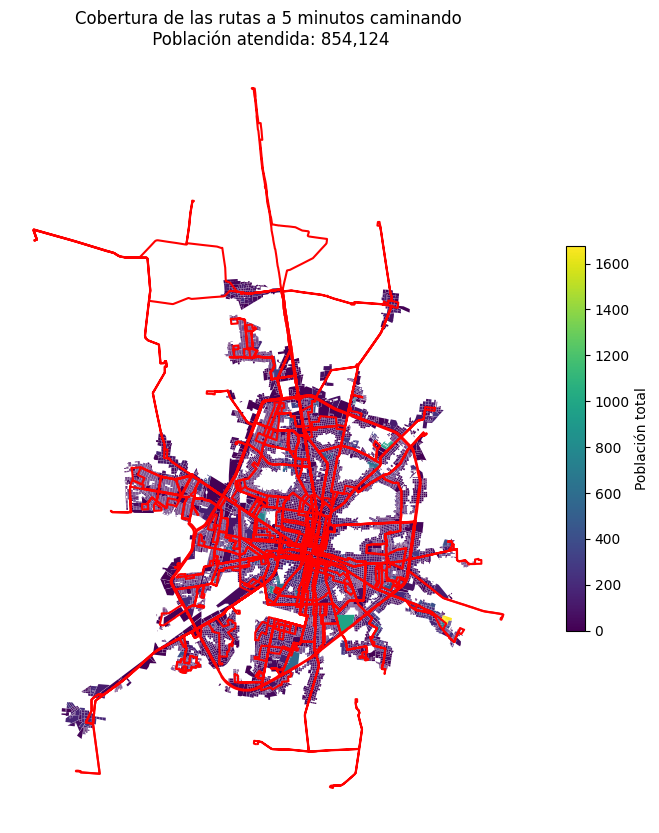

In [ ]:
ax = manz_rutas_atendidas_base.plot(column="POBTOT", figsize=(10, 10),
                    legend=True,
                    legend_kwds={"label": "Población total", "shrink": 0.5})
gtfs_base.get_rutas().plot(ax=ax, color="r")
ax.set_title(f"Cobertura de las rutas a {t} minutos caminando\n Población atendida: {manz_rutas_atendidas_base['POBTOT'].sum():,}")
ax.set_axis_off()

# Datos

In [2]:
# Rutas de TP
datos = "../datos"
rutas_json = f"{datos}/rutas_merida_geo/rutas_merida.geojson"
rutas = gpd.read_file(rutas_json)
rutas.head(2)

,shape_id,route_id,geometry
0,1070D-1,1070,"LINESTRING (-89.67631 20.99132, -89.67676 20.9..."
1,1071D-1,1071,"LINESTRING (-89.67619 20.9904, -89.67518 20.99..."


In [11]:
# Isocronas
t = 5
isocronas_pob_gpkg = f"{datos}/isocronas_mza_pob_merida_2020.gpkg"
iso = gpd.read_file(isocronas_pob_gpkg, encoding='utf-8', layer=f"{t}_minutos_pob", columns=['CVEGEO', 'geometry'])
iso.head(2)

,CVEGEO,geometry
0,3101300010080014,"POLYGON ((-89.51673 21.07314, -89.51673 21.073..."
1,3101300010080022,"POLYGON ((-89.50964 21.07181, -89.50935 21.070..."


In [4]:
# Manzanas INEGI
bbox_merida = 3764086,1034675,3792830,1069982
manzanas_shp = f"{datos}/31_Manzanas_INV2020_shp/INV2020_IND_PVEU_MZA_31.shp"
manz = gpd.read_file(manzanas_shp, encoding='utf-8', bbox=bbox_merida)\
    .to_crs(epsg=4326)
manz["POBTOT"] = manz["POBTOT"].astype(int)
manz.head(2)

,CVEGEO,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_AGEB,CVE_MZA,AMBITO,...,DRENAJEP_D,TRANSCOL_D,ACESOPER_D,ACESOAUT_D,PUESSEMI_D,PUESAMBU_D,FECHA_POLI,FECHA_INF,FECHA_CEU,geometry
0,3101300010095034,31,Yucatán,013,Conkal,0001,Conkal,0095,034,Urbana,...,Alguna vialidad,Ninguna vialidad,Restricción en ninguna vialidad,Restricción en ninguna vialidad,Ninguna vialidad,Ninguna vialidad,2020,2020,2020,"POLYGON ((-89.51199 21.07117, -89.512 21.07111..."
1,3101300010131016,31,Yucatán,013,Conkal,0001,Conkal,0131,016,Urbana,...,Ninguna vialidad,Ninguna vialidad,Restricción en ninguna vialidad,Restricción en ninguna vialidad,Ninguna vialidad,Ninguna vialidad,2020,2020,2020,"POLYGON ((-89.53608 21.05312, -89.53746 21.054..."


# Número de rutas por manzanas

In [8]:
# Calcula el número de rutas de TP en cada manzana
rutas_tp_10_w = gpd.sjoin(
    iso[["CVEGEO", "geometry"]],
    rutas[["geometry"]],
    how='left', predicate='intersects'
    )["CVEGEO"].value_counts()\
    .rename("rutas_tp_10w")

manz_tp_10w = manz.set_index("CVEGEO")[["geometry", "POBTOT"]]\
    .join(rutas_tp_10_w)\
    .assign(rutas_tp_10w_pob=lambda x: x["rutas_tp_10w"].div(x["POBTOT"]).mul(100))

manz_tp_10w.loc[lambda x: x["POBTOT"]==0, "rutas_tp_10w_pob"] = 0
manz_tp_10w.head(2)

,geometry,POBTOT,rutas_tp_10w,rutas_tp_10w_pob
CVEGEO,,,,
3101300010095034,"POLYGON ((-89.51199 21.07117, -89.512 21.07111...",55,2.0,3.636364
3101300010131016,"POLYGON ((-89.53608 21.05312, -89.53746 21.054...",31,2.0,6.451613


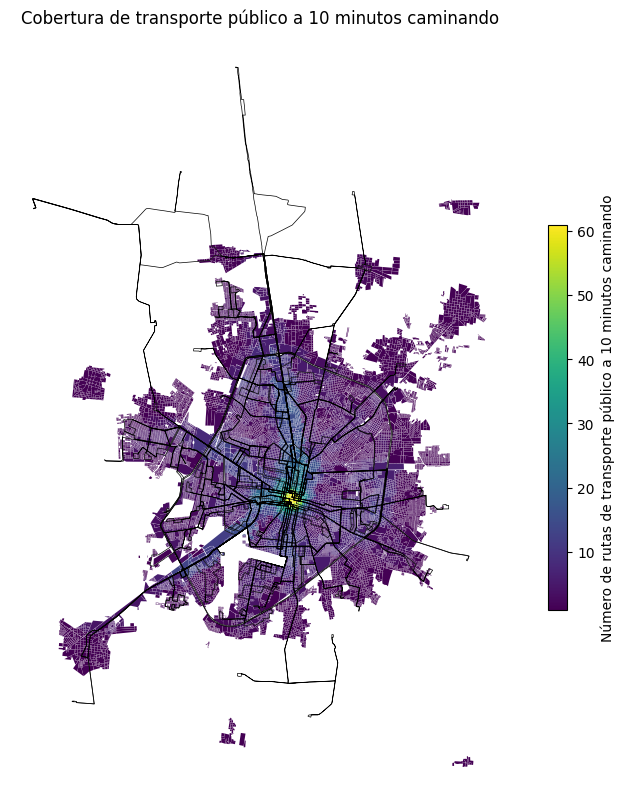

In [9]:
# Grafica de manzanas con cobertura de TP a 10 minutos
ax = manz_tp_10w.plot(column="rutas_tp_10w",
                      figsize=(10, 10),
                      legend=True,
                      legend_kwds={"label": "Número de rutas de transporte público a 10 minutos caminando",
                                   "shrink": 0.5},)
rutas.plot(ax=ax, color="k", linewidth=0.5)
ax.set_title("Cobertura de transporte público a 10 minutos caminando")
ax.set_axis_off()

In [10]:
# manz_tp_10w.explore(column="rutas_tp_10w")

In [11]:
# Grafica de manzanas con cobertura de TP a 10 minutos como proporcion de la población
#manz_tp_10w.query("rutas_tp_10w_pob<100").plot(column="rutas_tp_10w_pob", figsize=(10, 10), legend=True)

In [16]:
rutas.head(2)

,shape_id,route_id,geometry
0,1070D-1,1070,"LINESTRING (-89.67631 20.99132, -89.67676 20.9..."
1,1071D-1,1071,"LINESTRING (-89.67619 20.9904, -89.67518 20.99..."
